In [ ]:
## Assignement 9 - Neural Networks -- Submitted by John Manuel
##                                 -- Submitted to Abayomi Bello


## import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight


## neural network library
from keras.models import Sequential
from keras.layers import Dense, Dropout
from mlxtend.plotting import plot_confusion_matrix
import pickle


In [7]:
## Load the dataset
diabetes = pd.read_csv("diabetes.csv")
diabetes


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [8]:
# Replace 0s with np.nan 
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes[cols] = diabetes[cols].replace(0, np.nan)

In [9]:

diabetes.info(), 
# Show the updated missing value counts
missing_counts = diabetes[cols].isna().sum()
missing_counts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

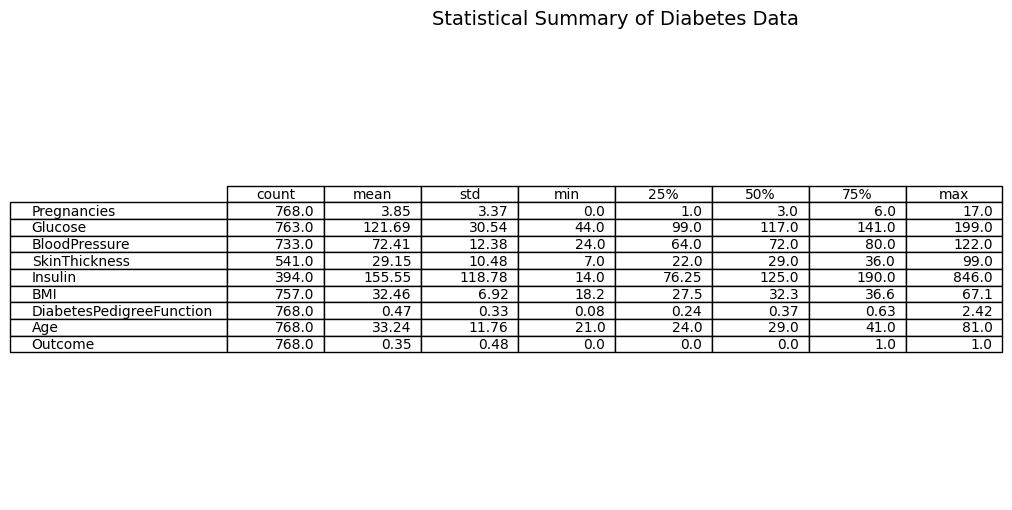

In [10]:
# Generate summary statistics
summary = diabetes.describe().round(2).T

# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
table = ax.table(cellText=summary.values,
                 colLabels=summary.columns,
                 rowLabels=summary.index,
                 loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("Statistical Summary of Diabetes Data", fontsize=14, pad=10)
plt.show()

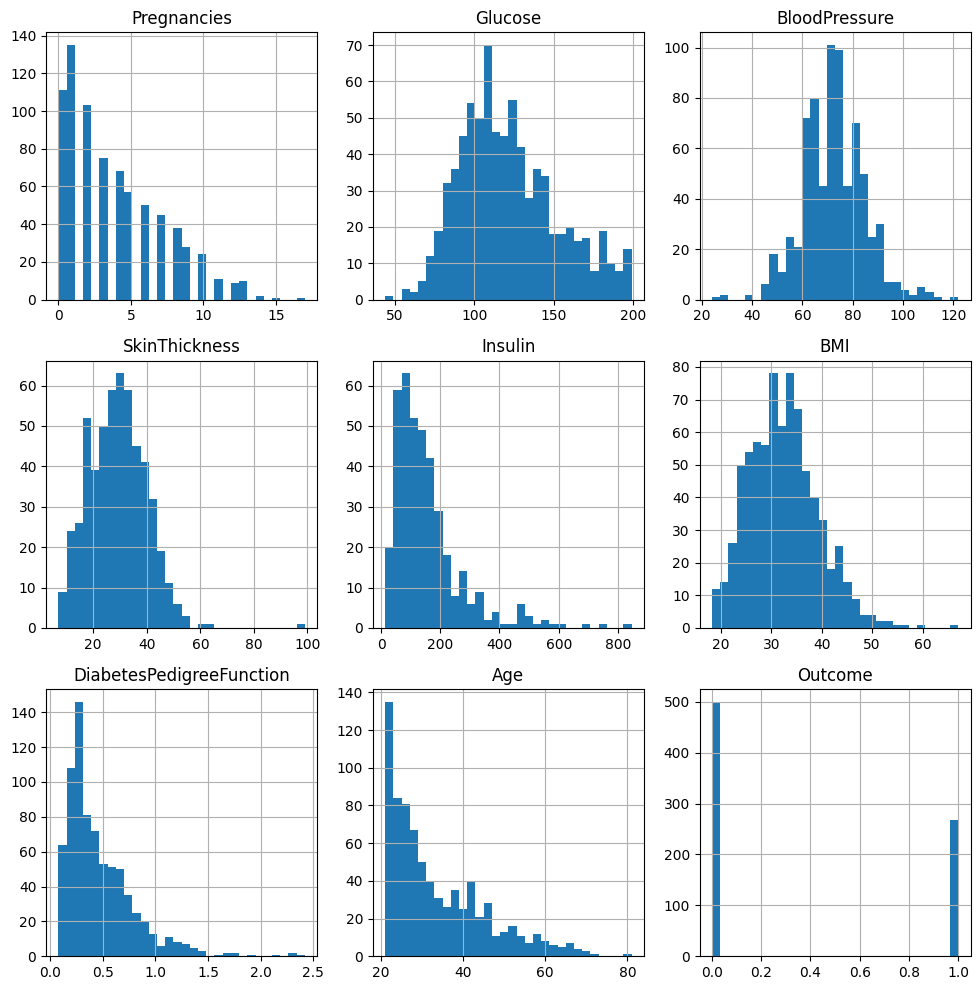

In [11]:
## Visually check the data 

diabetes.hist(bins=30, figsize=(10, 10))
plt.tight_layout()    

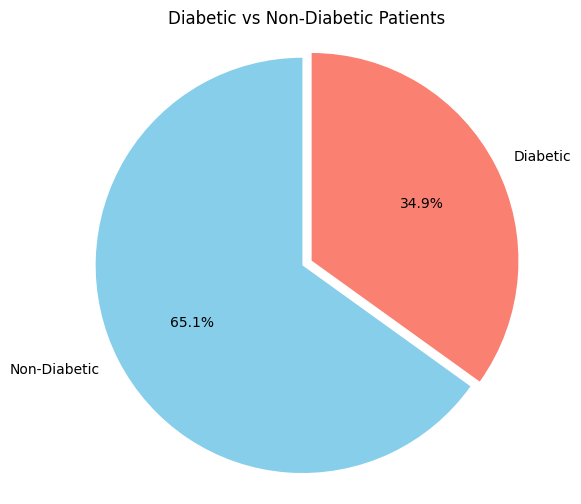

In [12]:
# How many diabetic (1) vs non-diabetic (0)?
outcome_counts = diabetes['Outcome'].value_counts()
labels = ['Non-Diabetic', 'Diabetic']
colors = ['skyblue', 'salmon']
# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=[0.05, 0])
plt.title('Diabetic vs Non-Diabetic Patients')
plt.axis('equal')  
plt.show()

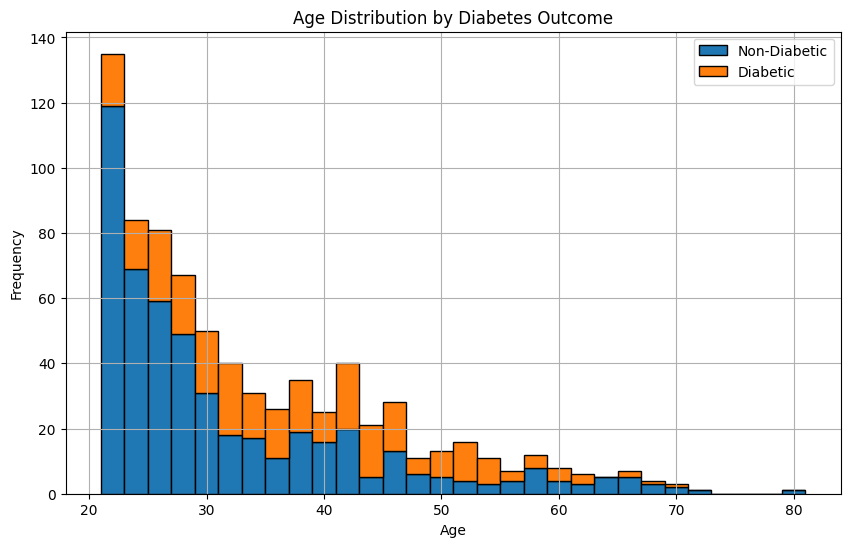

In [13]:
# Age distribution split by diabetic status
plt.figure(figsize=(10, 6))
plt.hist([diabetes[diabetes['Outcome'] == 0]['Age'],
          diabetes[diabetes['Outcome'] == 1]['Age']],
         bins=30, label=['Non-Diabetic', 'Diabetic'], stacked=True, edgecolor='black')
plt.title('Age Distribution by Diabetes Outcome')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

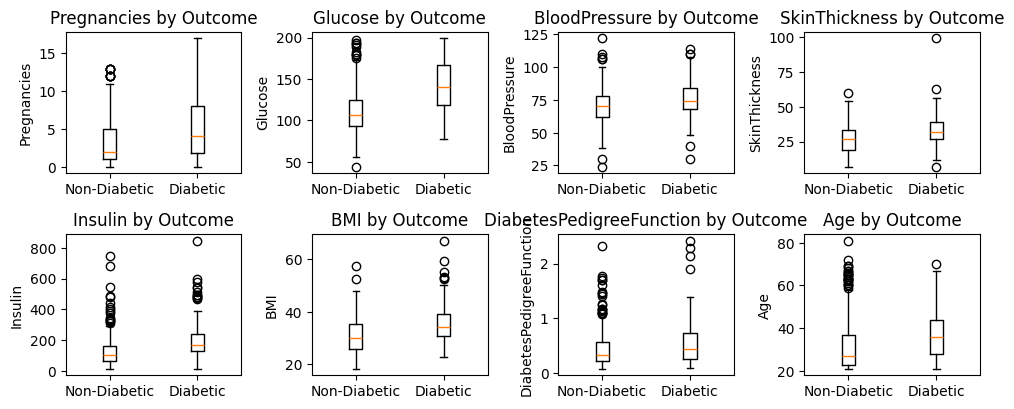

In [14]:
# Boxplot vs Outcomes to summarise a features's distribution
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.subplot(4, 4, i+1)
    plt.boxplot([
        diabetes[diabetes['Outcome'] == 0][feature].dropna(),
        diabetes[diabetes['Outcome'] == 1][feature].dropna()
    ],
    tick_labels=['Non-Diabetic', 'Diabetic'])
    plt.title(f'{feature} by Outcome')
    plt.ylabel(feature)


plt.tight_layout()
plt.show()

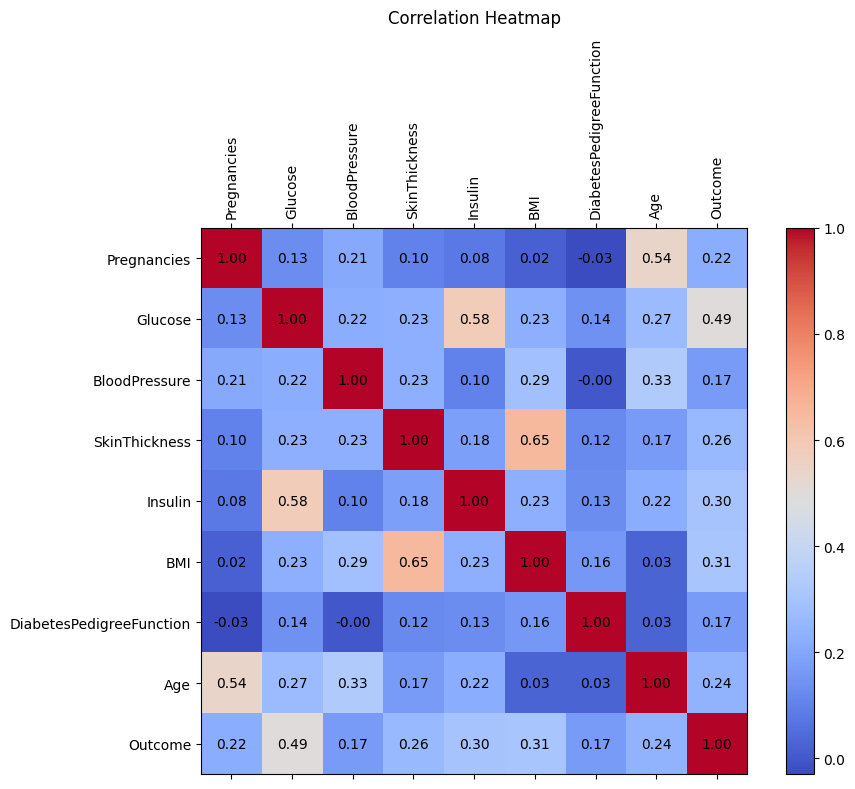

In [15]:
# Compute correlation matrix (standard decimal format)
corr = diabetes.corr().round(2)
# Plot heatmap 
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm')
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", va='center', ha='center', color='black')
# Axis labels
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
fig.colorbar(cax)
plt.title("Correlation Heatmap", pad=10)
plt.tight_layout()
plt.show()


In [16]:
# Further pre-prcoessing
# replacing NaN values with median

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
diabetes[cols] = imputer.fit_transform(diabetes[cols])


In [17]:
# defining independent and dependent variables
x = diabetes.drop("Outcome", axis=1)
y = diabetes["Outcome"]


In [18]:
# Scale the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [19]:
## train-test split 
x_train, x_test, y_train,y_test = train_test_split(x_scaled,y,test_size=0.4,random_state=23)

In [20]:
# Instantiating the SVM algorithm  (we focus on the diabetes cases because diabetes is a positive class, which the model cannot afford to miss (false negatives))
#Create a SVM Classifier
svm_linear = svm.SVC(kernel='linear')
svm_sigmoid = svm.SVC(kernel='sigmoid') 
svm_rbf = svm.SVC(kernel='rbf') 

# Fitting the model 
svm_linear.fit(x_train, y_train)
svm_sigmoid.fit(x_train, y_train)
svm_rbf.fit(x_train, y_train)

# Predicting the test variables
y_pred_linear = svm_linear.predict(x_test)
y_pred_sigmoid = svm_sigmoid.predict(x_test)
y_pred_rbf = svm_rbf.predict(x_test)

# Gather reports
models = {
    "Linear": y_pred_linear,
    "Sigmoid": y_pred_sigmoid,
    "RBF": y_pred_rbf
}

# results table with both class 0 and 1
results = []

for name, preds in models.items():
    report = metrics.classification_report(y_test, preds, output_dict=True)
    results.append({
        "Kernel": name,
        "Class": "Non-Diabetic (0)",
        "Precision": round(report["0"]["precision"], 2),
        "Recall": round(report["0"]["recall"], 2),
        "F1-Score": round(report["0"]["f1-score"], 2),
        "Support": report["0"]["support"],
        "Accuracy": round(report["accuracy"], 2)
    })
    results.append({
        "Kernel": name,
        "Class": "Diabetic (1)",
        "Precision": round(report["1"]["precision"], 2),
        "Recall": round(report["1"]["recall"], 2),
        "F1-Score": round(report["1"]["f1-score"], 2),
        "Support": report["1"]["support"],
        "Accuracy": round(report["accuracy"], 2)
    })

# Convert to DataFrame
comparison = pd.DataFrame(results)
print(comparison)


    Kernel             Class  Precision  Recall  F1-Score  Support  Accuracy
0   Linear  Non-Diabetic (0)       0.78    0.86      0.82    197.0      0.76
1   Linear      Diabetic (1)       0.70    0.57      0.63    111.0      0.76
2  Sigmoid  Non-Diabetic (0)       0.73    0.81      0.77    197.0      0.69
3  Sigmoid      Diabetic (1)       0.58    0.47      0.52    111.0      0.69
4      RBF  Non-Diabetic (0)       0.78    0.84      0.81    197.0      0.75
5      RBF      Diabetic (1)       0.67    0.58      0.62    111.0      0.75


In [21]:
## confussion matrix for the kernels
conf_mat_linear = confusion_matrix(y_test, y_pred_linear)
conf_mat_sigmoid = confusion_matrix(y_test, y_pred_sigmoid)
conf_mat_rbf = confusion_matrix(y_test, y_pred_rbf)

print(conf_mat_linear)
print(conf_mat_sigmoid)
print(conf_mat_rbf)

[[170  27]
 [ 48  63]]
[[160  37]
 [ 59  52]]
[[166  31]
 [ 47  64]]


In [22]:
## make a dataframe prediction for linear kernel
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear})

,Actual,Predicted
93,1,0
228,0,1
424,1,1
635,1,0
684,0,0
...,...,...
421,0,0
767,0,0
329,0,0
120,1,1


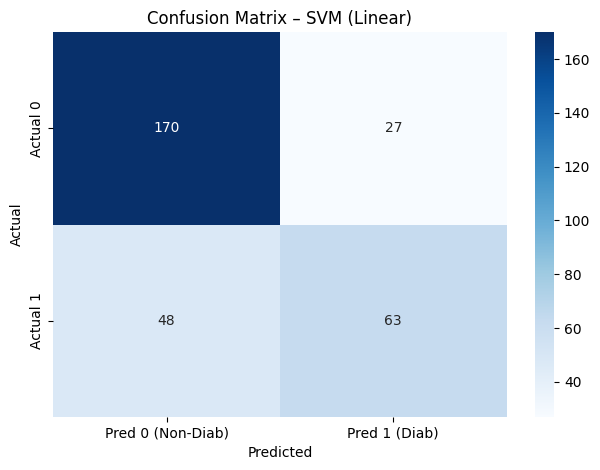

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       197
           1       0.70      0.57      0.63       111

    accuracy                           0.76       308
   macro avg       0.74      0.72      0.72       308
weighted avg       0.75      0.76      0.75       308



In [ ]:
# Confusion Matrix and Heatmap for SVM model
sns.heatmap(conf_mat_linear, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Pred 0 (Non-Diab)', 'Pred 1 (Diab)'],yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – SVM (Linear)")
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred_linear))

In [24]:
auc = roc_auc_score(y_test, y_pred_linear)
print('AUC: %f' %auc)

AUC: 0.715256


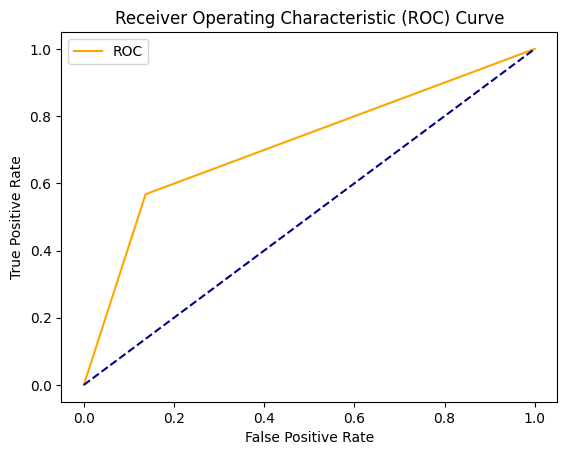

In [ ]:
# ROC Curve for SVM model
fpr, tpr = roc_curve(y_test, y_pred_linear)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# 1 Hidden Layer
# Initialise the NN
model1 = Sequential()

# input layer 
## 8 features, it will automatically take care of the samples 
model1.add(Input(shape=(8,)))

# Hidden layer 1
model1.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu'))
model1.add(Dropout(0.4))


# Output layer
# for regression, no activation function
# 0 and 1 ------ 1
# multi-class classification -- 1,2,3,4 ---- 4

## multi class clasification --- softmax --- number of classes that you have as output
## binary classification which will produce 0 and 1 we use the sigmoid activation function 
model1.add(Dense(units=1, kernel_initializer='he_uniform', activation='sigmoid'))

# Compile the ANN
## mean squared error
## metrics mae
## categorical_crossentropy
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history1 = model1.fit(x_train, y_train, batch_size=25, epochs=40, validation_split=0.25)

# prediction
y_pred_1 = (model1.predict(x_test) > 0.5).astype("int")


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4676 - loss: 0.8689 - val_accuracy: 0.4609 - val_loss: 0.8472
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4500 - loss: 0.8592 - val_accuracy: 0.4783 - val_loss: 0.8273
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4213 - loss: 0.8785 - val_accuracy: 0.5130 - val_loss: 0.8082
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5372 - loss: 0.7931 - val_accuracy: 0.5217 - val_loss: 0.7919
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5220 - loss: 0.7801 - val_accuracy: 0.5391 - val_loss: 0.7760
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5765 - loss: 0.7369 - val_accuracy: 0.5565 - val_loss: 0.7628
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5720 - loss: 0.7175 - val_accuracy: 0.5652 - val_loss: 0.7497
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5297 - loss: 0.7588 - val_accuracy: 0.5652 - val_loss

In [54]:
val_accuracy = np.mean(history1.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 60.15%


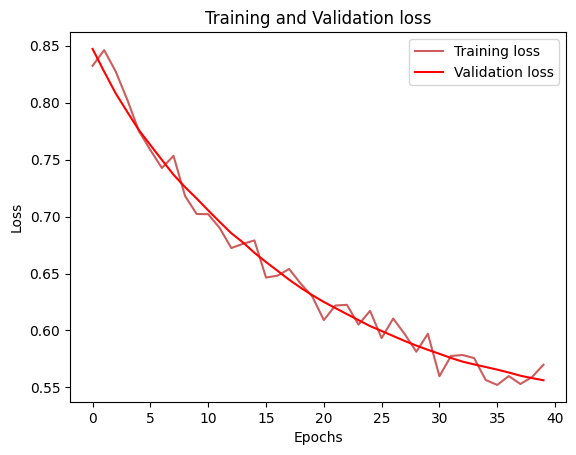

In [ ]:
# Training and Validation Loss Graph for 2-layer NN Model
history_df = pd.DataFrame(history1.history)

plt.plot(history_df.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

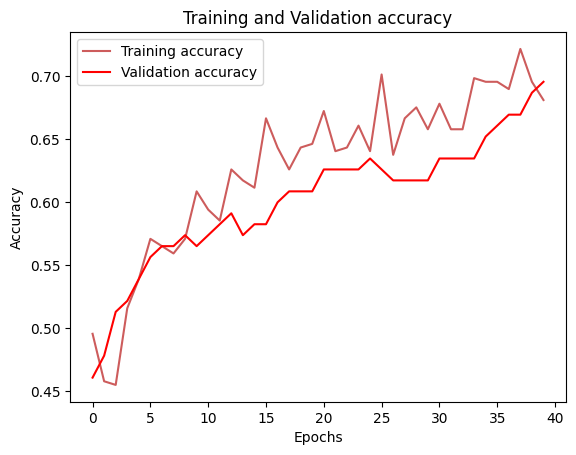

In [ ]:
# Training and Validation Accuracy Graph for 1-Layer NN model
history_df = pd.DataFrame(history1.history)

plt.plot(history_df.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


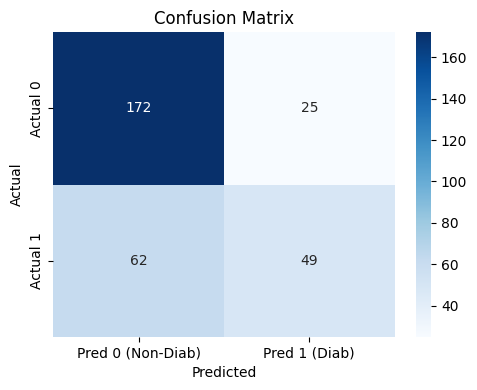

Classification Report – 1 Hidden Layer
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       197
           1       0.66      0.44      0.53       111

    accuracy                           0.72       308
   macro avg       0.70      0.66      0.66       308
weighted avg       0.71      0.72      0.70       308



In [ ]:
# Confusion Matrix and Classification Report for the 1-Layer NN Model
y_pred_prob = model1.predict(x_test)
y_pred = (y_pred_1 > 0.4).astype("int")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
#  Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt=".0f",cmap="Blues", xticklabels=['Pred 0 (Non-Diab)', 'Pred 1 (Diab)'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("Classification Report – 1 Hidden Layer")
print(classification_report(y_test, y_pred))


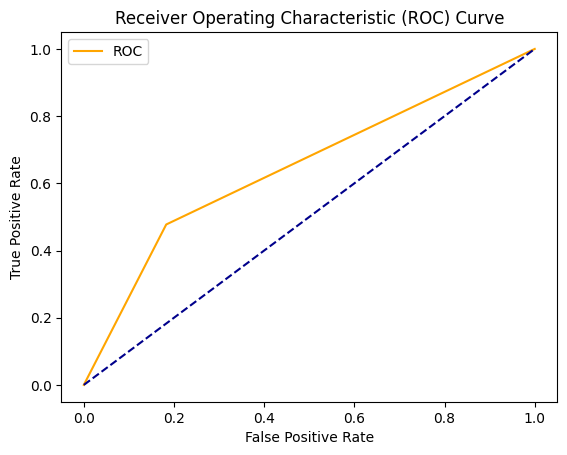

In [ ]:
# ROC-AUC curve for the 1-Layer NN model
fpr, tpr = roc_curve(y_test, y_pred_1)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

# 2 Hidden Layer NN Model
# Initialise the NN
model2 = Sequential()

# input layer 
## 12 features, it will automatically take care of the samples 
model2.add(Input(shape=(8,)))

# Hidden layer 1
model2.add(Dense(units=6, kernel_initializer='he_uniform', activation='relu'))
model2.add(Dropout(0.4))

# Hidden layer 2
model2.add(Dense(units=4, kernel_initializer='he_uniform', activation='relu'))
model2.add(Dropout(0.2))

# Output layer
# for regression, no activation function
# 0 and 1 ------ 1
# multi-class classification -- 1,2,3,4 ---- 4

## multi class clasification --- softmax --- number of classes that you have as output
## binary classification which will produce 0 and 1 we use the sigmoid activation function 
model2.add(Dense(units=1, kernel_initializer='he_uniform', activation='sigmoid'))

# Compile the ANN
## mean squared error
## metrics mae
## categorical_crossentropy
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history2 = model2.fit(x_train, y_train, batch_size=25, epochs=40, validation_split=0.25)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5705 - loss: 0.7290 - val_accuracy: 0.6261 - val_loss: 0.6764
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6335 - loss: 0.7155 - val_accuracy: 0.6261 - val_loss: 0.6685
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6455 - loss: 0.7161 - val_accuracy: 0.6522 - val_loss: 0.6622
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6738 - loss: 0.6805 - val_accuracy: 0.6435 - val_loss: 0.6568
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6769 - loss: 0.6727 - val_accuracy: 0.6522 - val_loss: 0.6508
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6120 - loss: 0.6837 - val_accuracy: 0.6957 - val_loss: 0.6449
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6231 - loss: 0.7210 - val_accuracy: 0.7130 - val_loss: 0.6386
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7214 - loss: 0.6421 - val_accuracy: 0.7130 - val_loss

In [120]:
val_accuracy = np.mean(history2.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 70.24%


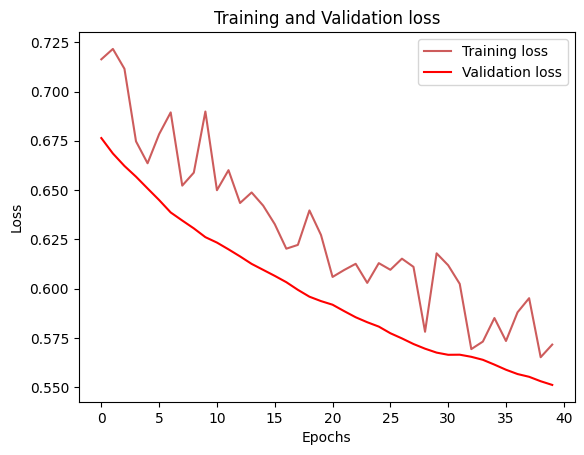

In [ ]:
# Training and Validation Loss Graph for 2-layer NN Model
history_dd = pd.DataFrame(history2.history)

plt.plot(history_dd.loc[:, ['loss']], "#CD5C5C", label='Training loss')
plt.plot(history_dd.loc[:, ['val_loss']],"#FF0000", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

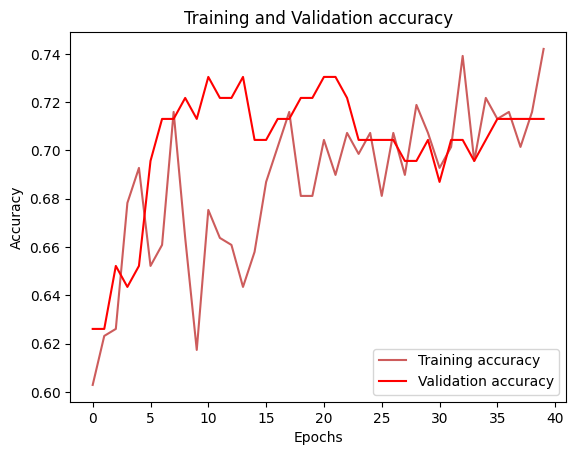

In [ ]:
# Training and Validation Accuracy Graph for 2-Layer NN model
history_dd = pd.DataFrame(history2.history)

plt.plot(history_dd.loc[:, ['accuracy']], "#CD5C5C", label='Training accuracy')
plt.plot(history_dd.loc[:, ['val_accuracy']],"#FF0000", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


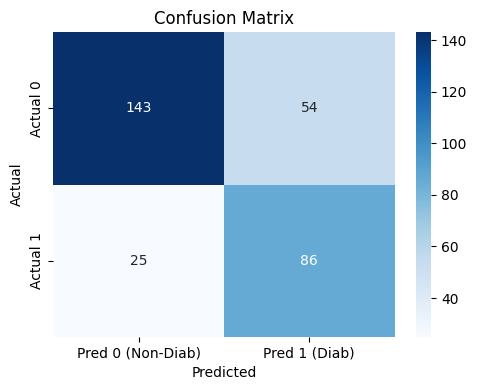

Classification Report – 2 Hidden Layers
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       197
           1       0.61      0.77      0.69       111

    accuracy                           0.74       308
   macro avg       0.73      0.75      0.73       308
weighted avg       0.77      0.74      0.75       308



In [ ]:
# Confusion Matrix and Classification Report for the 2 Layer NN Model
y_pred_2 = model2.predict(x_test)
y_pred2 = (y_pred_2 > 0.4).astype("int")
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred2)
#  Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt=".0f",cmap="Blues", xticklabels=['Pred 0 (Non-Diab)', 'Pred 1 (Diab)'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print("Classification Report – 2 Hidden Layers")
print(classification_report(y_test, y_pred2))

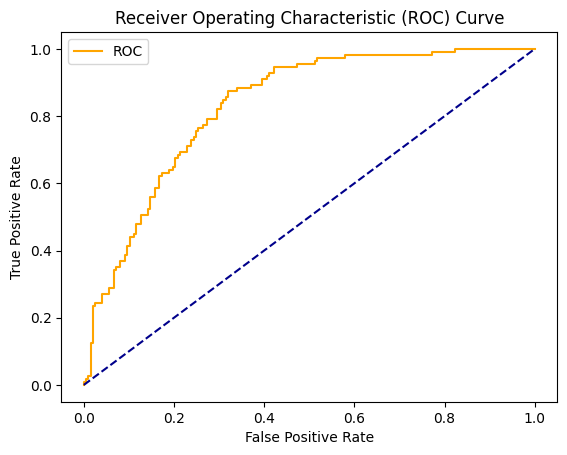

In [ ]:
# ROC-AUC curve for the 2-Layer NN model

fpr, tpr = roc_curve(y_test, y_pred_2)[0:2]

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()